# ABIDE Subtype analysis
The goal of this notebook is to run a subtype analysis on the ABIDE dataset and to look at the subtype weights following Pierre Orban's analysis. Here are the central research questions:

1. What are subtypes of scores maps for different networks (7 network resolution on Cambridge) and how do they look like?
2. What are the individual subject weights for these subtypes (violin plots and Pierre's matrix)
3. For which networks and subtypes is diagnosis a significant predictor of weights?
4. What do weights for these subtypes and networks look like for patients and healthy controls?
5. For which networks and subtypes are dimensional scores like IQ significant predictors of weights?
5. What does the scatterplot of weights over IQ look like?

In [206]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
# Paths
scale = 12
subtypes = 3
network_number = 1
net_id = network_number - 1
mtp = 'stability_maps'
tpl = '*_fmri_{:07d}_session_1_run1_stability_maps.nii.gz'
data_path = '/data1/abide/Out/Scores/sc{:02d}/time'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_3box_189_sample.csv'
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'

In [9]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [16]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)
# Grab the corresponding file paths - should be sure that they exist
path_list = [glob.glob(os.path.join(data_path, mtp, tpl.format(r['SUB_ID'])))[0] for i, r in pheno.iterrows()]

In [171]:
# Get the scores maps into a voxel by subject array
# Init store
n_files = len(path_list)
n_vox = np.sum(mask)
net_stack = np.zeros((n_vox, n_files))
# Init timer
timer = bb.tools.Counter(n_files)
# Iterate files
for index, s_path in enumerate(path_list):
    # Timer
    timer.tic()
    # Getting data
    f_net = nib.load(s_path).get_data()[mask][..., net_id]
    net_stack[..., index] = f_net
    # Timer
    timer.toc()
    timer.progress(timer.total - timer.count)

 100.0 % done 0.00 seconds to go. One step takes 0.08592 and we ran for 16.40 so far

In [177]:
# Get the grand average
grand_average = np.reshape(np.mean(net_stack, 1), (net_stack.shape[0], 1))
# Demean the net stack
net_stack = net_stack - grand_average

In [178]:
# Build correlation matrix on the network stack
corr_mat = np.corrcoef(net_stack, rowvar=0)
# Compute linkage with Ward's criterion
link_mat = scl.hierarchy.linkage(corr_mat, method='ward')
# Partition the linkage to get a given number of subtypes
part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')

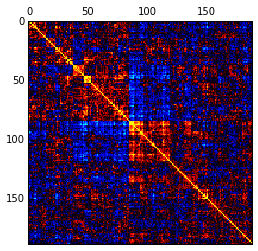

In [179]:
# Take a look at the subject by subject correlation matrix
idx = scl.hierarchy.dendrogram(link_mat, no_plot=True)['leaves']

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111, aspect='auto')
tmp = ax.matshow(corr_mat[idx,:][:,idx], cmap=hotcold, vmin=-0.2, vmax=0.2)

## Build the subtypes and compute the weights

In [180]:
# Init store - Build subtypes
sub_stack = np.zeros((n_vox, subtypes))
for s_id in range(subtypes):
    sub_stack[:,s_id] = np.mean(net_stack[:, part_sub==s_id+1],1)

# Init store - Compute the weights
weights = np.zeros((n_files, subtypes))
for s_id in range(subtypes):
    type_map = sub_stack[:, s_id]
    weights[:, s_id] = np.array([np.corrcoef(type_map, net_stack[:,x])[0,1] for x in range(n_files)])

In [93]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

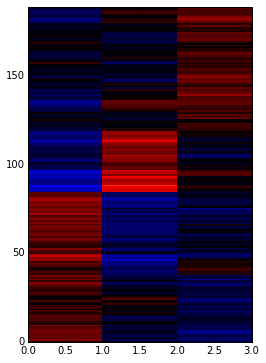

In [184]:
# Take a look at the weights
ind = np.argsort(part_sub)

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111, aspect='auto')
tmp = ax.pcolor(weights[idx, :], cmap=hotcold, vmin=-1, vmax=1)
tmp = ax.set_ylim([0, 189])

In [185]:
# Median centered and maximum absolute deviation
med = np.median(sub_stack,0)
mad = sm.robust.scale.mad(sub_stack)
norm = (sub_stack - med)/mad
# Recalculate the weights on the normalized maps
# Init store - Compute the weights
norm_weights = np.zeros((n_files, subtypes))
for s_id in range(subtypes):
    type_map = norm[:, s_id]
    norm_weights[:, s_id] = np.array([np.corrcoef(type_map, net_stack[:,x])[0,1] for x in range(n_files)])

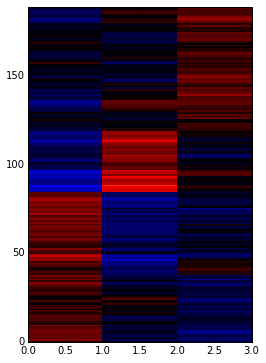

In [187]:
# Take a look at the new weights
ind = np.argsort(part_sub)

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111, aspect='auto')
tmp = ax.pcolor(norm_weights[idx, :], cmap=hotcold, vmin=-1, vmax=1)
tmp = ax.set_ylim([0, 189])

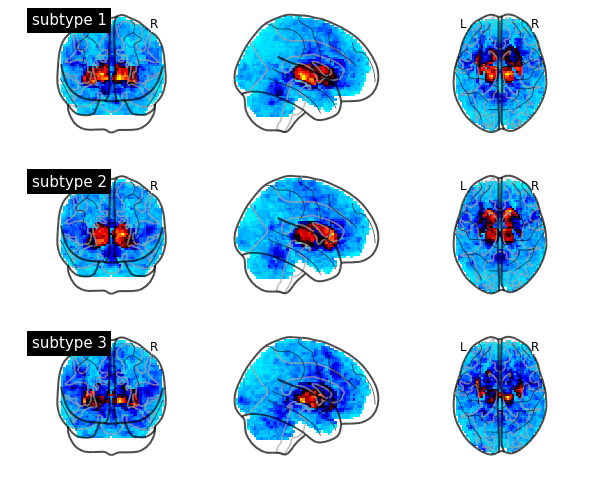

In [188]:
# Take a look at the subtypes
# Load the mask again to get the image
n_sbt = sub_stack.shape[1]
# Prepare the figure
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(n_sbt, 1, hspace=0.3)
for s_id in range(n_sbt):
    sbt_map = sub_stack[:, s_id]
    # Remap the map into volume space
    template = np.zeros_like(mask, dtype=np.float64)
    template[mask] = sbt_map
    # Make a nifti image out of the volume
    nifti_vol = nib.Nifti1Image(template, affine=m_img.get_affine(), header=m_img.get_header())
    # Visualize the thing with nilearn
    ax = fig.add_subplot(gs[s_id,0])
    nlp.plot_glass_brain(nifti_vol, title='subtype {}'.format(s_id+1),axes=ax, cmap=hotcold)

In [ ]:
# Take a look at the subtypes
visu_subtype

##Build the GLM

In [189]:
# Generate the model matrix
factors = ['DX_GROUP', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

In [191]:
# Run the GLM
model = sm.OLS(weights[:,0], glm_pheno)
results = model.fit()

In [196]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     5.531
Date:                Fri, 21 Aug 2015   Prob (F-statistic):           5.51e-08
Time:                        14:46:42   Log-Likelihood:                 85.393
No. Observations:                 189   AIC:                            -144.8
Df Residuals:                     176   BIC:                            -102.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2506      0.065      3.865      

In [230]:
scale = 12
subtypes = 5
# Let's run the model again for all networks and subtypes
pval_store = np.zeros((scale, subtypes))
timer = bb.tools.Counter(scale * subtypes)
for net_id in range(scale):
    timer.tic()
    # Get the scores maps into a voxel by subject array
    # Init store
    n_files = len(path_list)
    n_vox = np.sum(mask)
    net_stack = np.zeros((n_vox, n_files))
    # Iterate files
    for index, s_path in enumerate(path_list):
        # Getting data
        f_net = nib.load(s_path).get_data()[mask][..., net_id]
        net_stack[..., index] = f_net
    
    grand_average = np.reshape(np.mean(net_stack, 1), (net_stack.shape[0], 1))
    # Demean the net stack
    net_stack = net_stack - grand_average
    
    # Build correlation matrix on the network stack
    corr_mat = np.corrcoef(net_stack, rowvar=0)
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat, method='ward')
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    
    # Init store - Build subtypes
    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sub_stack[:,s_id] = np.mean(net_stack[:, part_sub==s_id+1],1)

    # Init store - Compute the weights
    weights = np.zeros((n_files, subtypes))
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weights[:, s_id] = np.array([np.corrcoef(type_map, net_stack[:,x])[0,1] for x in range(n_files)])
        
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(weights[:,s_id], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues['DX_GROUP']
        timer.toc()
    timer.progress()

 100.0 % done 0.00 seconds to go. One step takes 16.33943 and we ran for 199.37 so far

<matplotlib.colorbar.Colorbar instance at 0x14ab85f0>

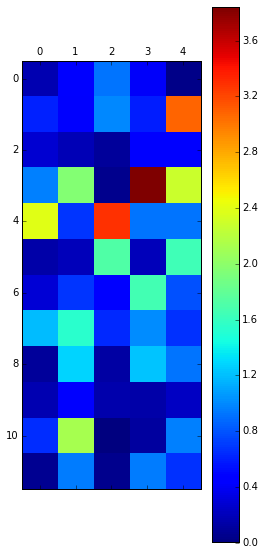

In [231]:
plt.matshow(-np.log10(pval_store))
plt.colorbar()

In [232]:
# FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)

<matplotlib.colorbar.Colorbar instance at 0x14bcac20>

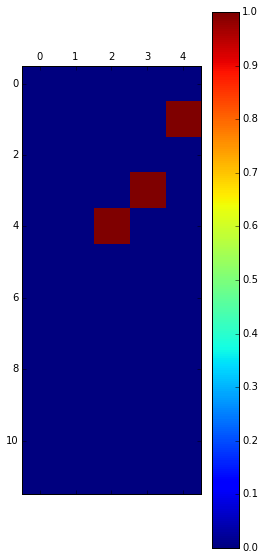

In [233]:
plt.matshow(pcorr_store)
plt.colorbar()

In [235]:
pcorr_store

array([[False, False, False, False, False],
       [False, False, False, False,  True],
       [False, False, False, False, False],
       [False, False, False,  True, False],
       [False, False,  True, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]], dtype=bool)